1.

In [2]:
#bringing in, cleaning, and merging datasets
import pandas as pd
#import the csv files
weather = pd.read_csv("seattle-weather.csv")
reports = pd.read_csv("SPD_Reports.csv")


#remove data that will be unused
reports.drop(columns=["Offense Description", "Block", "District","Beat","2000 Census Tract","Longitude","Latitude","Offense Start Date","Offense End Date"],inplace=True)

#fix data types
reports["Report Date"] = pd.to_datetime(reports["Report Date"])
weather["date"] = pd.to_datetime(weather["date"])

weather_mapping = {'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}
weather["weather"] = weather["weather"].map(weather_mapping)

# Define the date range covered by data sets
start_date = pd.to_datetime("2014-01-17")
end_date = pd.to_datetime("2015-12-31")

# Filter out unusable records
reports_filtered = reports[(reports["Report Date"] >= start_date) & (reports["Report Date"] <= end_date)]
weather_filtered = weather[(weather["date"] >= start_date) & (weather["date"] <= end_date)]

#merge datasets
merged_data = pd.merge(weather_filtered, reports_filtered.groupby('Report Date').size().reset_index(name='Offense Count'), left_on="date", right_on="Report Date", how="left")
merged_data['Offense Count'].fillna(0, inplace=True)
merged_data.head()


,date,precipitation,temp_max,temp_min,wind,weather,Report Date,Offense Count
0,2014-01-17,0.0,5.6,2.8,2.3,2,2014-01-17,2.0
1,2014-01-18,0.0,9.4,0.6,2.2,2,NaT,0.0
2,2014-01-19,0.0,6.1,3.3,2.5,2,2014-01-19,2.0
3,2014-01-20,0.0,10.0,2.8,2.2,2,NaT,0.0
4,2014-01-21,0.0,10.0,1.7,1.5,2,NaT,0.0


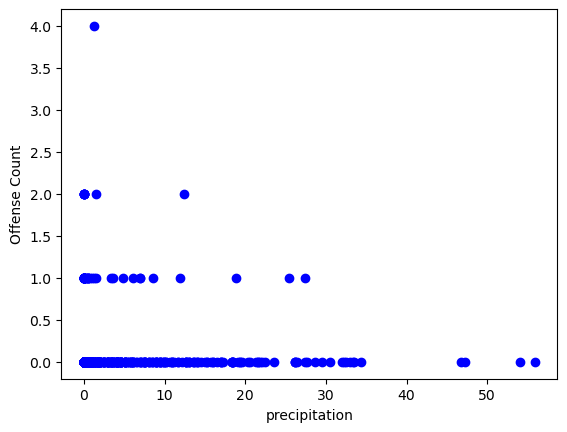

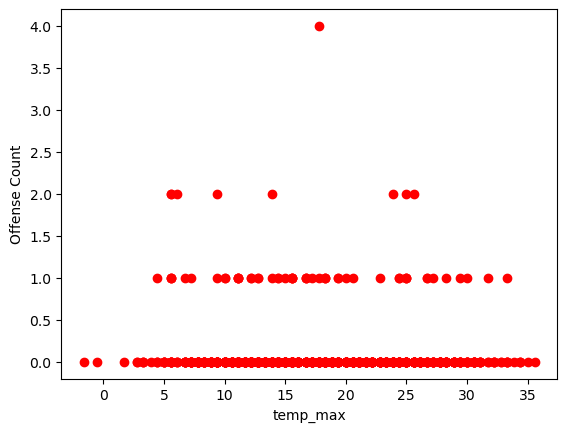

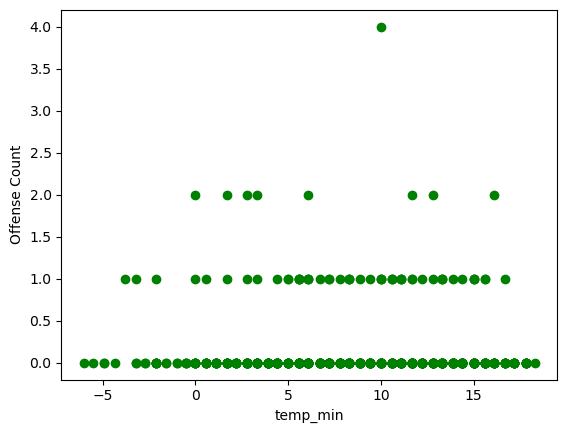

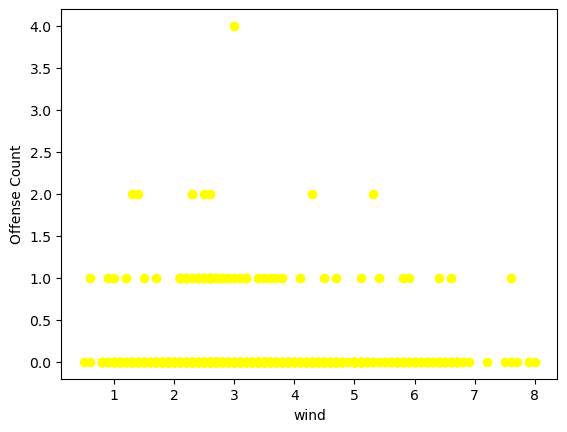

In [3]:
import matplotlib.pyplot as plt

plt.scatter(merged_data["precipitation"], merged_data["Offense Count"], color="blue")
plt.xlabel("precipitation")
plt.ylabel("Offense Count")
plt.show()

plt.scatter(merged_data["temp_max"], merged_data["Offense Count"], color="red")
plt.xlabel("temp_max")
plt.ylabel("Offense Count")
plt.show()

plt.scatter(merged_data["temp_min"], merged_data["Offense Count"], color="green")
plt.xlabel("temp_min")
plt.ylabel("Offense Count")
plt.show()

plt.scatter(merged_data["wind"], merged_data["Offense Count"], color="yellow")
plt.xlabel("wind")
plt.ylabel("Offense Count")
plt.show()



The goal is to use precipitation, temp_max, temp_min, and wind to predict the number of offenses that happened on that day. The graphs show that as weather conditions approach less desirable numbers, the number of crimes committed also decreases.

In [4]:
from sklearn.tree import DecisionTreeClassifier
X = merged_data[["temp_max","precipitation","temp_min","wind"]]
Y = merged_data["Offense Count"]

tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X,Y)

DecisionTreeClassifier()

In [5]:
from sklearn.metrics import confusion_matrix
y_predicted = tree_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)


[[654   0   0   0]
 [  0  51   0   0]
 [  0   0   8   0]
 [  0   0   0   1]]


Looks way too good to be true. Probably overfitting

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print ("Accuracy is ", accuracy_score(Y, y_predicted))

# We have to specify how to combine for the multiclassifications
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


Accuracy is  1.0
Precision is  1.0
Sensitivity is  1.0
F1 is  1.0


In [7]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
    
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)
    


Cross validation accuracies are:  [0.7692307692307693, 0.8531468531468531, 0.8321678321678322, 0.8811188811188811, 0.8098591549295775]
Cross validation f1 scores  are:  [0.7905138339920948, 0.8589703149036944, 0.8398186580004762, 0.8937993486156345, 0.7941031402422317]


These accuraces are really high compared to what i was expecting. Even if the scores droped form the perfect 1 that it was I still think they are high. 

In [8]:
print(merged_data["Offense Count"].value_counts())
print("Number of records in data set:",merged_data["Offense Count"].count())
print("% of records that are zero", 654/714)

Offense Count
0.0    654
1.0     51
2.0      8
4.0      1
Name: count, dtype: int64
Number of records in data set: 714
% of records that are zero 0.9159663865546218


Never mind those predictions are bad. roughly 92% of the values are 0 so having a prediction rate around 80% is bad. 

In [9]:
from sklearn.svm import SVC
X = merged_data[["temp_max","precipitation","temp_min","wind"]]
Y = merged_data["Offense Count"]

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X,Y)

SVC(kernel='linear')

In [10]:
from sklearn.metrics import confusion_matrix
y_predicted = svm_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


[[654   0   0   0]
 [ 51   0   0   0]
 [  8   0   0   0]
 [  1   0   0   0]]
Accuracy is  0.9159663865546218
Precision is  0.838994421297931
Sensitivity is  0.9159663865546218
F1 is  0.8757924222320508


C:\Users\s553982\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This model has better accuracy than the first but it predicts 0 for every data point. this is not a desired result.

My models have suffered due to a lack of data points in other catagorise compared to the number of zeros. What would happen if we reduced the training data to only contain 100 data points for zero Offences commited

In [11]:
category_to_reduce = merged_data[merged_data['Offense Count'] == 0.0]

category_to_reduce = category_to_reduce.sample(frac=1, random_state=42)
category_to_reduce_subset = category_to_reduce.head(100)

merged_data = merged_data.drop(category_to_reduce.index)
merged_data = pd.concat([merged_data, category_to_reduce_subset], ignore_index=True)

print(merged_data["Offense Count"].value_counts())
print("Number of records in data set:",merged_data["Offense Count"].count())
print("% of records that are zero", 100/160)

Offense Count
0.0    100
1.0     51
2.0      8
4.0      1
Name: count, dtype: int64
Number of records in data set: 160
% of records that are zero 0.625


In [12]:
X = merged_data[["temp_max","precipitation","temp_min","wind"]]
Y = merged_data["Offense Count"]

tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X,Y)


from sklearn.metrics import confusion_matrix
y_predicted = tree_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))

# We have to specify how to combine for the multiclassifications
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
    
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

[[100   0   0   0]
 [  0  51   0   0]
 [  0   0   8   0]
 [  0   0   0   1]]
Accuracy is  1.0
Precision is  1.0
Sensitivity is  1.0
F1 is  1.0
Cross validation accuracies are:  [0.40625, 0.5, 0.4375, 0.4375, 0.5]
Cross validation f1 scores  are:  [0.44400406504065043, 0.4019607843137255, 0.42447916666666663, 0.47687728937728946, 0.5092905405405406]


still really bad

In [13]:
from sklearn.svm import SVC
X = merged_data[["temp_max","precipitation","temp_min","wind"]]
Y = merged_data["Offense Count"]

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X,Y)

SVC(kernel='linear')

In [14]:
from sklearn.metrics import confusion_matrix
y_predicted = svm_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
    
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

[[100   0   0   0]
 [ 51   0   0   0]
 [  8   0   0   0]
 [  1   0   0   0]]
Accuracy is  0.625
Precision is  0.390625
Sensitivity is  0.625
F1 is  0.48076923076923084
Cross validation accuracies are:  [0.40625, 0.53125, 0.5, 0.4375, 0.46875]
Cross validation f1 scores  are:  [0.44579562594268474, 0.4524936868686869, 0.48190789473684215, 0.47687728937728946, 0.47986111111111107]


C:\Users\s553982\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Still predicting the same thing for everything. These models appear to be ineffective. There appears to be no correlation to be found within the dataset ive selected. I will now preform the same operations but trying to predict weather condition rather than Offense Count. 

In [17]:
weather = pd.read_csv("seattle-weather.csv")
weather.dropna()

weather_mapping = {'drizzle': 0, 'rain': 1, 'sun': 2, 'snow': 3, 'fog': 4}
weather["weather"] = weather["weather"].map(weather_mapping)

X = weather[["temp_max","precipitation","temp_min","wind"]]
Y = weather["weather"]

tree_classifier = DecisionTreeClassifier()
tree_classifier.fit(X,Y)

y_predicted = tree_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


[[ 53   0   0   0   0]
 [  1 640   0   0   0]
 [  2   0 638   0   0]
 [  0   0   0  26   0]
 [  0   0   1   0 100]]
Accuracy is  0.9972621492128679
Precision is  0.9973710809996491
Sensitivity is  0.9972621492128679
F1 is  0.9972876343122347


Well it looks like it did a pretty good job of splitting them into catagories. lets see what cross validation shows

In [18]:
validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=145)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
    
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)
 

Cross validation accuracies are:  [0.7372013651877133, 0.7534246575342466, 0.7808219178082192, 0.7294520547945206, 0.7636986301369864]
Cross validation f1 scores  are:  [0.7493579751886955, 0.7763231123774975, 0.7804903930896234, 0.7323060424598999, 0.7749028762975089]


Cross validation shows that the predictions are not as acruate as the training set shows. lets look at what a base model would do on this data

In [23]:
print(weather["weather"].value_counts())
print("Number of records in data set:",weather["weather"].count())
print("% of records that are one:", 641/1461)

weather
1    641
2    640
4    101
0     53
3     26
Name: count, dtype: int64
Number of records in data set: 1461
% of records that are one: 0.43874058863791926


This model actually appears to be good at predicting things compared to my previous ones. 

In [27]:
from sklearn.svm import SVC
X = weather[["temp_max","precipitation","temp_min","wind"]]
Y = weather["weather"]

svm_classifier = SVC(kernel="linear")
svm_classifier.fit(X,Y)

y_predicted = svm_classifier.predict(X)
matrix = confusion_matrix(Y, y_predicted)
print(matrix)

print ("Accuracy is ", accuracy_score(Y, y_predicted))
print ("Precision is ", precision_score(Y, y_predicted, average="weighted"))
print ("Sensitivity is ", recall_score(Y, y_predicted, average="weighted"))
print ("F1 is ", f1_score(Y, y_predicted, average="weighted"))


validation_accuracy = []
validation_f1 =[]
fold_and_validate = KFold(n_splits=5, shuffle=True, random_state=12)
for train_set_indices, validation_set_indices in fold_and_validate.split(X):
    cv_train_set = X.iloc[train_set_indices]
    cv_train_target = Y.iloc[train_set_indices]
    #print(cv_train_set)
    
    cv_decision_tree = DecisionTreeClassifier()
    cv_decision_tree.fit(cv_train_set, cv_train_target)
    
    cv_xvalidation = X.iloc[validation_set_indices]
    cv_y_true = Y.iloc[validation_set_indices]
    cv_y_predicted = cv_decision_tree.predict(cv_xvalidation)
    
    cv_accuracy_score = accuracy_score(cv_y_true, cv_y_predicted)
    cv_f1_score = f1_score(cv_y_true, cv_y_predicted,  average="weighted")

    validation_accuracy.append(cv_accuracy_score)
    validation_f1.append(cv_f1_score)
    
print("Cross validation accuracies are: ", validation_accuracy)
print("Cross validation f1 scores  are: ", validation_f1)

[[  0   0  53   0   0]
 [  0 597  44   0   0]
 [  0   0 640   0   0]
 [  0  20   0   6   0]
 [  0   0 101   0   0]]
Accuracy is  0.8507871321013005
Precision is  0.77686848622074
Sensitivity is  0.8507871321013005
F1 is  0.8024654511081195
Cross validation accuracies are:  [0.8054607508532423, 0.7808219178082192, 0.7397260273972602, 0.791095890410959, 0.7191780821917808]
Cross validation f1 scores  are:  [0.7991479545735407, 0.773871909963878, 0.7465216704688776, 0.7886965884724806, 0.7176456685409036]


C:\Users\s553982\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This one does not appear to be all in all that great. It does not predict two of the options. however, its accuracies are better than the previous ones. 

In [28]:
What I learned:

SyntaxError: invalid syntax (4143009557.py, line 1)